In [2]:
# =========================================================
# === SETUP UNTUK MENGGUNAKAN GPU DI KAGGLE (CUDF & CUML) ===
# =========================================================
!nvidia-smi
!pip install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com

Tue Oct 28 01:48:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# =========================================================
# === IMPORT DAN LOAD DATASET ===
# =========================================================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Coba gunakan cuDF (GPU DataFrame) jika tersedia
try:
    import cudf
    gpu_available = True
    print("cuDF terdeteksi: menggunakan GPU untuk pemrosesan data.")
except ImportError:
    gpu_available = False
    print("cuDF tidak ditemukan: menggunakan pandas (CPU).")

# --- Path dataset ---
path = "/kaggle/input/train-sisrek/train.csv"
if not os.path.exists(path):
    raise FileNotFoundError(f"Dataset tidak ditemukan di path: {path}")

# --- Load dataset ---
if gpu_available:
    df = cudf.read_csv(path)
else:
    df = pd.read_csv(path)

# --- Tampilkan beberapa data awal ---
print("=== Contoh Data ===")
print(df.head())

# --- Info dataset ---
print("\n=== Info Dataset ===")
if gpu_available:
    print(df.info(null_counts=True))
else:
    print(df.info())

# --- Deskripsi statistik ---
print("\n=== Statistik Deskriptif ===")
print(df.describe())

# --- Jumlah data, user, dan item ---
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()

print("\n=== Ringkasan Dataset ===")
print("Jumlah baris data:", len(df))
print("Jumlah user unik:", int(n_users))
print("Jumlah item unik:", int(n_items))


cuDF terdeteksi: menggunakan GPU untuk pemrosesan data.
=== Contoh Data ===
   user_id     item_id
0        8  0002005018
1        8  074322678X
2        8  0887841740
3        8  1552041778
4        8  1567407781

=== Info Dataset ===
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 269764 entries, 0 to 269763
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  269764 non-null  int64
 1   item_id  269764 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.7+ MB
None

=== Statistik Deskriptif ===
             user_id
count  269764.000000
mean   134442.794105
std     80545.073149
min         8.000000
25%     65663.000000
50%    131238.000000
75%    204663.000000
max    278854.000000

=== Ringkasan Dataset ===
Jumlah baris data: 269764
Jumlah user unik: 13876
Jumlah item unik: 123069



--- Statistik Interaksi ---
Rata-rata interaksi per user : 19.44
Rata-rata interaksi per item : 2.19


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


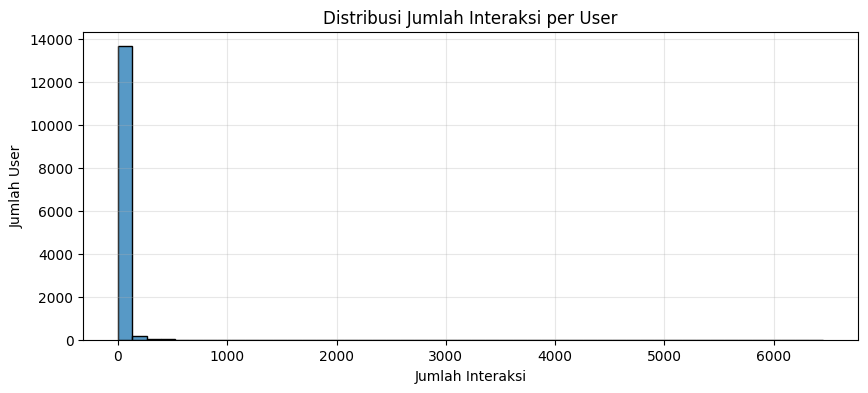

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


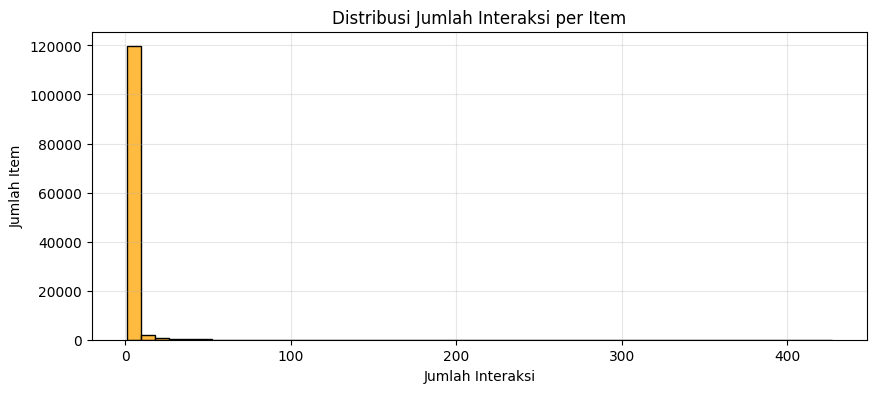


=== SPARSITY DATA ===
Tingkat sparsity: 99.98%
(Semakin tinggi nilainya, semakin jarang user berinteraksi dengan item)


In [4]:
# =========================================================
# === ANALISIS DISTRIBUSI INTERAKSI DAN SPARSITY DATASET ===
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- Hitung interaksi per user dan per item ---
interaksi_user = df.groupby('user_id')['item_id'].count()
interaksi_item = df.groupby('item_id')['user_id'].count()

# Jika pakai cuDF, ubah ke pandas untuk visualisasi
if gpu_available:
    interaksi_user_pd = interaksi_user.to_pandas()
    interaksi_item_pd = interaksi_item.to_pandas()
else:
    interaksi_user_pd = interaksi_user
    interaksi_item_pd = interaksi_item

print("\n--- Statistik Interaksi ---")
print(f"Rata-rata interaksi per user : {interaksi_user_pd.mean():.2f}")
print(f"Rata-rata interaksi per item : {interaksi_item_pd.mean():.2f}")

# --- Visualisasi distribusi interaksi per user ---
plt.figure(figsize=(10,4))
sns.histplot(interaksi_user_pd, bins=50, kde=False)
plt.title('Distribusi Jumlah Interaksi per User')
plt.xlabel('Jumlah Interaksi')
plt.ylabel('Jumlah User')
plt.grid(alpha=0.3)
plt.show()

# --- Visualisasi distribusi interaksi per item ---
plt.figure(figsize=(10,4))
sns.histplot(interaksi_item_pd, bins=50, kde=False, color='orange')
plt.title('Distribusi Jumlah Interaksi per Item')
plt.xlabel('Jumlah Interaksi')
plt.ylabel('Jumlah Item')
plt.grid(alpha=0.3)
plt.show()

# --- Hitung sparsity (kelangkaan data) ---
total_possible = int(n_users) * int(n_items)
sparsity = (1 - len(df) / total_possible) * 100

print("\n=== SPARSITY DATA ===")
print(f"Tingkat sparsity: {sparsity:.2f}%")
print("(Semakin tinggi nilainya, semakin jarang user berinteraksi dengan item)")


In [5]:
# POPULARITY
# Pastikan kolom penting ada: user_id dan item_id
assert 'user_id' in df.columns and 'item_id' in df.columns, "Kolom user_id atau item_id tidak ditemukan!"

# Hitung popularitas item 
# Kita hitung seberapa sering item muncul
item_popularity = df['item_id'].value_counts().reset_index()
item_popularity.columns = ['item_id', 'popularity_score']

# Buat fungsi rekomendasi berdasarkan popularitas
def recommend_top_items_for_user(user_id, n=10):
    """Memberikan Top-N item populer yang belum pernah digunakan user"""
    user_items = df[df['user_id'] == user_id]['item_id'].unique()
    recommended = item_popularity[~item_popularity['item_id'].isin(user_items)].head(n)
    return recommended

user_sample = df['user_id'].iloc[0]
recommendations = recommend_top_items_for_user(user_sample, n=10)
print(f"Top 10 rekomendasi untuk user {user_sample}:")
print(recommendations)

Top 10 rekomendasi untuk user 8:
      item_id  popularity_score
0  0316666343               427
1  0385504209               330
2  0312195516               241
3  0142001740               214
4  059035342X               206
5  0060928336               204
6  0446672211               197
7  0345337662               183
8  0452282152               173
9  0316601950               169


In [ ]:
# =========================================================
# === ITEM-BASED COLLABORATIVE FILTERING (IBCF) — ITERATIF PER 1000 DATA ===
# =========================================================
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd

batch_size = 1000
num_batches = int(np.ceil(len(df) / batch_size))

print(f"Total data: {len(df)} | Diproses dalam {num_batches} batch (masing-masing {batch_size} baris)")

# List untuk menyimpan hasil similarity per batch
similarity_batches = []

for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(df))
    df_batch = df.iloc[start:end]

    # pastikan dataframe di CPU
    if 'cudf' in str(type(df_batch)):
        df_batch = df_batch.to_pandas()

    # buat user-item matrix (binary implicit)
    user_item_matrix = (
        df_batch.groupby(['user_id', 'item_id'])
        .size()
        .unstack(fill_value=0)
    )
    user_item_matrix = (user_item_matrix > 0).astype(int)
    
    if user_item_matrix.shape[1] < 2:
        print(f"Batch {i+1} dilewati (terlalu sedikit item unik)")
        continue

    # ubah ke format sparse untuk efisiensi
    user_item_sparse = csr_matrix(user_item_matrix.values)

    # hitung cosine similarity antar item
    item_similarity = cosine_similarity(user_item_sparse.T, dense_output=False)
    item_similarity_df = pd.DataFrame(
        item_similarity.toarray(),
        index=user_item_matrix.columns,
        columns=user_item_matrix.columns
    )

    # simpan hasil similarity ke list
    similarity_batches.append(item_similarity_df)

    print(f"Iterasi {i+1}/{num_batches} selesai | Data: {len(df_batch)} | Item unik: {user_item_matrix.shape[1]}")

print("\n=== Semua batch selesai diproses ===")
print(f"Total batch similarity tersimpan: {len(similarity_batches)}")

# --- Gabungkan semua similarity dengan rata-rata (opsional) ---
item_similarity_df = pd.concat(similarity_batches).groupby(level=0).mean()
print("Similarity global terbentuk.")

# --- Hitung popularitas item untuk fallback ---
item_popularity = (
    df.groupby('item_id')['user_id']
    .count()
    .sort_values(ascending=False)
    .reset_index()
)
item_popularity.columns = ['item_id', 'popularity']

# --- Fungsi rekomendasi ---
def ibcf_recommend(user_id, n=10):
    """
    Memberikan rekomendasi berdasarkan item yang pernah digunakan user.
    Jika user belum memiliki interaksi, kembalikan item populer.
    """
    user_items = df[df['user_id'] == user_id]['item_id'].unique()

    if len(user_items) == 0:
        print(f"User {user_id} tidak ditemukan. Menampilkan item populer.")
        return item_popularity.head(n)

    available_items = [i for i in user_items if i in item_similarity_df.columns]
    if not available_items:
        print(f"Tidak ada item user {user_id} yang terdapat di similarity matrix.")
        return item_popularity.head(n)

    sim_scores = item_similarity_df[available_items].sum(axis=1)
    sim_scores = sim_scores.drop(available_items, errors='ignore')
    
    recommended_items = sim_scores.sort_values(ascending=False).head(n).reset_index()
    recommended_items.columns = ['item_id', 'similarity_score']
    return recommended_items

# --- Contoh uji rekomendasi ---
user_sample = df['user_id'].iloc[0]
print(f"\nMenampilkan rekomendasi untuk user: {user_sample}")
ibcf_recommendations = ibcf_recommend(user_sample, n=10)
print(f"\nTop 10 rekomendasi IBCF untuk user {user_sample}:")
print(ibcf_recommendations)


Total data: 269764 | Diproses dalam 270 batch (masing-masing 1000 baris)
Iterasi 1/270 selesai | Data: 1000 | Item unik: 969
Iterasi 2/270 selesai | Data: 1000 | Item unik: 986
Iterasi 3/270 selesai | Data: 1000 | Item unik: 994
Iterasi 4/270 selesai | Data: 1000 | Item unik: 979
Iterasi 5/270 selesai | Data: 1000 | Item unik: 975
Iterasi 6/270 selesai | Data: 1000 | Item unik: 962
Iterasi 7/270 selesai | Data: 1000 | Item unik: 950
Iterasi 8/270 selesai | Data: 1000 | Item unik: 969
Iterasi 9/270 selesai | Data: 1000 | Item unik: 979
Iterasi 10/270 selesai | Data: 1000 | Item unik: 993
Iterasi 11/270 selesai | Data: 1000 | Item unik: 1000
Iterasi 12/270 selesai | Data: 1000 | Item unik: 1000
Iterasi 13/270 selesai | Data: 1000 | Item unik: 1000
Iterasi 14/270 selesai | Data: 1000 | Item unik: 1000
Iterasi 15/270 selesai | Data: 1000 | Item unik: 1000
Iterasi 16/270 selesai | Data: 1000 | Item unik: 999
Iterasi 17/270 selesai | Data: 1000 | Item unik: 982
Iterasi 18/270 selesai | Data: